# Imports and Useful Methods

In [3]:
from nes_py.wrappers import JoypadSpace
import gym_super_mario_bros
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT
import gym
import matplotlib.pyplot as plt
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import gym.wrappers as gw
device = T.device("cuda:0" if T.cuda.is_available() else "cpu")
from collections import deque 
import copy
from random import randrange
from torchsummary import summary
from tqdm import tqdm
import random

# 1) Random Agent


## Implementation

In [8]:
# Agent that makes moves at random
class RandomAgent:
    def __init__(self, env):
        self.env = env
        self.data = [] # Index i represents the distance traveled by the agent 
                       # at iteration i of the last call to run
        
    # Runs the RandomAgent for iters iterations
    def run(self, iters):
        print("Training initialized for {} episodes".format(iters))
        self.clearData()
        for i in range(iters):
            done = False
            info = None
            env.reset()
            reward = 0
            while not done: # Runs until the environment determines a singular game has ended
                action = env.action_space.sample()
                obs, reward, terminated, truncated, info = env.step(action)
                reward += reward
                done = terminated or truncated
            print("Episode {} reward: {}".format(i + 1, reward))
            self.data.append(reward)
    
    def getData(self):
        return self.data
    
    def clearData(self):
        self.data = []

## Performance calculator

#### Use the total reward gained by the agent for a performance metric

Training initialized for 10 episodes
Episode 0 reward: -30
Episode 1 reward: -30
Episode 2 reward: -30
Episode 3 reward: -30
Episode 4 reward: -30
Episode 5 reward: -30
Episode 6 reward: -30
Episode 7 reward: -30
Episode 8 reward: -30
Episode 9 reward: -30


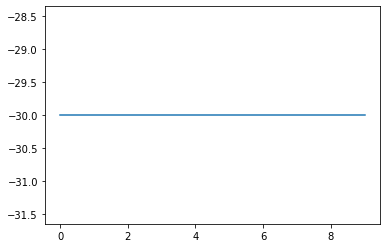

In [7]:
env = gym.make('SuperMarioBros-v0', apply_api_compatibility=True)
env = JoypadSpace(env, SIMPLE_MOVEMENT)

ra = RandomAgent(env)
ra.run(10)
env.close()
data = ra.getData()

plt.plot(data)
plt.show()



# 2) Double Deep Q Learning CNN

### Preprocessing the environment

In [4]:
# Taken from Yuansong Feng, Suraj Subramanian, Howard Wang, Steven Guo.
class SkipFrame(gym.Wrapper):
    def __init__(self, env, skip):
        """Return only every `skip`-th frame"""
        super().__init__(env)
        self._skip = skip

    def step(self, action):
        """Repeat action, and sum reward"""
        total_reward = 0.0
        for i in range(self._skip):
            # Accumulate reward and repeat the same action
            obs, reward, done, trunk, info = self.env.step(action)
            total_reward += reward
            if done:
                break
        return obs, total_reward, done, trunk, info


env = gym.make('SuperMarioBros-v0', apply_api_compatibility=True, render_mode="human")
env = JoypadSpace(env, SIMPLE_MOVEMENT)
# Grayscale
env = gw.GrayScaleObservation(env, keep_dim=True)
# Resizing the environment
env = gw.ResizeObservation(env, (84, 84))
# Stacking frames for context
env = gw.FrameStack(env, 4)
# Skipping n frames 
env = SkipFrame(env, 4)

C:\Users\bbaro\anaconda3\lib\site-packages\gym\envs\registration.py:555: UserWarning: WARN: The environment SuperMarioBros-v0 is out of date. You should consider upgrading to version `v3`.
  logger.warn(
C:\Users\bbaro\anaconda3\lib\site-packages\gym\envs\registration.py:627: UserWarning: WARN: The environment creator metadata doesn't include `render_modes`, contains: ['render.modes', 'video.frames_per_second']
  logger.warn(


## Replay buffer holds experiences that the network will use for action replay and batch training

In [5]:
class ReplayBuffer:
    def __init__(self, memory_size=20000):
        self.state = deque(maxlen=memory_size)
        self.action = deque(maxlen=memory_size)
        self.reward = deque(maxlen=memory_size)
        self.next_state = deque(maxlen=memory_size)
        self.done= deque(maxlen=memory_size)
    
    # Adds a transition
    def append(self, state, action, reward, next_state, done):
        def first_if_tuple(x):
            return x[0] if isinstance(x, tuple) else x
        state = first_if_tuple(state).__array__()
        next_state = first_if_tuple(next_state).__array__()
        
        state = T.tensor(state, device=device, dtype=T.float).permute(3, 0, 1, 2)
        next_state = T.tensor(next_state, device=device, dtype=T.float).permute(3, 0, 1, 2)
        action = T.tensor([action], device=device, dtype=T.long)
        reward = T.tensor([reward], device=device, dtype=T.float)
        done = T.tensor([done], device=device, dtype=T.float)
        
        self.state.append(state)
        self.action.append(action)
        self.reward.append(reward)
        self.next_state.append(next_state)
        self.done.append(done)

    def length(self):
        return len(self.done)
    
    def __len__(self):
        return self.length()

## Double Deep Q Learning Network using a Convolutional Neural Network

In [40]:
class DDQNetwork():
    def __init__(self, env, alpha = .0001, epsilon = 1, epsilon_decay = .99999, gamma = .99, batch_size = 32,
                 update_f = 4, target_update_f = 1024, memory=20000, input_c = 4, n_actions = 7):
        self.env = env
        self.alpha = alpha
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.gamma = gamma
        self.batch_size = batch_size
        self.update_f = update_f
        self.target_update_f = target_update_f
        self.save_every = 100000
        self.memory = ReplayBuffer(memory)
        self.input_c = input_c
        self.n_actions = n_actions
        self.total_steps = 0
        
        self.conv1 = nn.Conv2d(input_c, 32, kernel_size=6, stride=3) # Produces 27x27x32
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2) # Produces 13x13x64
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1) # Produces 11x11x64
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(11*11*64, 512) # Fully connected layer
        self.fc2 = nn.Linear(512, self.n_actions)
        
        self.model = nn.Sequential(self.conv1, nn.ReLU(), self.conv2, 
                                   nn.ReLU(), self.conv3, nn.ReLU(), nn.Flatten(), 
                                   self.fc1, nn.ReLU(), self.fc2)
        self.target_model = copy.deepcopy(self.model)
        
        self.model = self.model.to(device=device)
        self.target_model = self.target_model.to(device=device)
        for p in self.target_model.parameters():
            p.requires_grad = False
        self.currentEpochLoss = []
        self.optimizer = optim.Adam(self.model.parameters(), self.alpha)
        self.loss_fn = nn.SmoothL1Loss()
    
    def get_model(self):
        return self.model
    
    def get_target_model(self):
        return self.target_model
    
    # Adds a transition to the memory for use in the action replay
    def add_memory(self, state, action, reward, next_state, done):
        self.memory.append(state, action, reward, next_state, done)
    
    #Epsilon greedy exploration strategy
    def get_action(self, state):
        if randrange(0,1) < self.epsilon:
            return env.action_space.sample()
        else:
            a = np.argmax(self.model(state)[0])
            return a
        
    # Returns the best action for a given state
    def act(self, state):
        a = T.argmax(self.model(self.state_to_tensor(state))[0]).item()
        return a
    
    # Converts an env state to a valid tensor
    def state_to_tensor(self, state):
        def first_if_tuple(x):
            return x[0] if isinstance(x, tuple) else x
        state = first_if_tuple(state).__array__()
        t = T.tensor(np.array(state, dtype=np.float), dtype=T.float).permute(3, 0, 1, 2)
        t = t.to(device=device)
        return t

    # Trains the network for n epochs
    def train(self, epochs):
        for i in range(epochs):
            print("Epoch {} starting with epsilon {}".format(i + 1, self.epsilon))
                
            total_reward = 0
            j = 0
            # Resets the environment
            state = env.reset()
            
            while True:
                action = self.get_action(state)
                
                next_state, reward, terminated, truncated, _ = env.step(action)
                done = terminated or truncated
                total_reward += reward
                
                self.add_memory(state, action, reward, next_state, done)
            
                if self.total_steps % self.update_f == 0 and self.total_steps != 0 and self.memory.length() > self.batch_size:
                    self.actionReplay()
                
                if self.total_steps % self.target_update_f == 0 and self.total_steps !=0:
                    self.target_model.load_state_dict(self.model.state_dict())
                    
                if self.total_steps % self.save_every == 0 and self.total_steps !=0:
                    self.saveModel("model.pt")
                    
                state = next_state
                j += 1
                self.total_steps += 1
                if done:
                    break
               
            self.epsilon = max(.01, self.epsilon * self.epsilon_decay)
            print("Epoch {} finished in {} steps with a reward of {} and average loss of {}"
                  .format(i + 1, j, total_reward, sum(self.currentEpochLoss) / len(self.currentEpochLoss)))
            self.currentEpochLoss = []
                
                    
    # Performs one iteration of action replay of the given batch size. Replays states from agents memory
    # and compares its predictions with the expected results gathered from the target model.
    def actionReplay(self):
        indices = np.random.choice(range(len(self.memory)), size=self.batch_size)
        
        states = [self.memory.state[i] for i in indices]
        actions = [self.memory.action[i] for i in indices]
        rewards = [self.memory.reward[i] for i in indices]
        next_states = [self.memory.next_state[i] for i in indices]
        done = [self.memory.done[i] for i in indices]
        
        # Loop completes one batch of action replay
        for i in range(0, len(states)):
            s = states[i]
            ns = next_states[i]
            a = actions[i]
            current_q = self.model(s)
            next_a = T.argmax(self.model(ns))
            next_q = self.target_model(ns).detach()
        
            expected = T.clone(current_q).detach()
            
            if done[i]:
                expected[0][next_a] = rewards[i]
            else:
                expected[0][next_a] = rewards[i] + self.gamma * T.max(next_q)
            
            
            self.optimizer.zero_grad()
            loss = self.loss_fn(current_q, expected)
            self.currentEpochLoss.append(loss)
            loss.backward()
            self.optimizer.step() 
            
    # Saves the models to separate .pt files. Target network is labeled with prefix "t_"
    def saveModel(self, path):
        T.save(self.model, "checkpoint_{}_{}".format(self.total_steps, path))
        T.save(self.target_model, "t_checkpoint_{}_{}".format(self.total_steps, path))
        print("Successfully save model to {}".format(path))
    
    # Loads the models from .pt files of given path
    def loadModel(self, path):
        self.model = T.load(path)
        self.target_model = T.load("t_" + path)
        self.model = self.model.to(device=device)
        self.target_model = self.target_model.to(device=device)
        print("Successfully loaded model at {}".format(path))

## Agent that uses a trained DDQN for determining optimal policy

In [41]:
class DDQAgent:
    def __init__(self, env, model):
        self.env = env
        self.model = model
        self.data = [] # Index i represents the distance traveled by the agent 
                       # at iteration i of the last call to run
        
    # Runs the DDQAgent iters times
    def run(self, iters):
        self.clearData()
        for i in range(iters):
            done = False
            info = None
            obs = env.reset()
            t_reward = 0
            while not done: # Runs until the environment determines a singular game has ended
                action = model.act(obs)
                obs, reward, terminated, truncated, info = env.step(action)
                t_reward += reward
                done = terminated or truncated
            print("Episode {} reward: {}".format(i + 1, t_reward))
            self.data.append(reward)
    
    # Gets the reward data list
    def getData(self):
        return self.data
    
    # Resets the reward data list
    def clearData(self):
        self.data = []

In [ ]:
model = DDQNetwork(env)
model.loadModel("checkpoint_5000000_model.pt")
model.train(5000)
model.saveModel("smb_2.pt")

Successfully loaded model at checkpoint_5000000_model.pt
Epoch 1 starting with epsilon 1
Epoch 1 finished in 996 steps with a reward of 1460.0 and average loss of 0.3796137273311615
Epoch 2 starting with epsilon 0.99999
Epoch 2 finished in 433 steps with a reward of 1449.0 and average loss of 0.5490546822547913
Epoch 3 starting with epsilon 0.9999800001000001
Epoch 3 finished in 1047 steps with a reward of 2147.0 and average loss of 0.6991651654243469
Epoch 4 starting with epsilon 0.9999700002999992
Epoch 4 finished in 813 steps with a reward of 1795.0 and average loss of 0.7458937168121338
Epoch 5 starting with epsilon 0.9999600005999962
Epoch 5 finished in 1781 steps with a reward of 2167.0 and average loss of 0.6927570700645447
Epoch 6 starting with epsilon 0.9999500009999903
Epoch 6 finished in 3398 steps with a reward of 1657.0 and average loss of 0.5314425826072693
Epoch 7 starting with epsilon 0.9999400014999804
Epoch 7 finished in 822 steps with a reward of 1806.0 and average l

Epoch 58 finished in 1338 steps with a reward of 1841.0 and average loss of 0.41339603066444397
Epoch 59 starting with epsilon 0.9994201652691508
Epoch 59 finished in 671 steps with a reward of 1578.0 and average loss of 0.48921486735343933
Epoch 60 starting with epsilon 0.9994101710674982
Epoch 60 finished in 733 steps with a reward of 1050.0 and average loss of 0.4517686665058136
Epoch 61 starting with epsilon 0.9994001769657875
Epoch 61 finished in 956 steps with a reward of 1613.0 and average loss of 0.44943177700042725
Epoch 62 starting with epsilon 0.9993901829640179
Epoch 62 finished in 131 steps with a reward of 702.0 and average loss of 0.4621625542640686
Epoch 63 starting with epsilon 0.9993801890621884
Epoch 63 finished in 494 steps with a reward of 1602.0 and average loss of 0.3667326271533966
Epoch 64 starting with epsilon 0.9993701952602978
Epoch 64 finished in 1235 steps with a reward of 3126.0 and average loss of 0.48423337936401367
Epoch 65 starting with epsilon 0.9993

Successfully loaded model at checkpoint_5000000_model.pt
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


C:\Users\bbaro\AppData\Local\Temp/ipykernel_18276/324960426.py:66: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  t = T.tensor(np.array(state, dtype=np.float), dtype=T.float).permute(3, 0, 1, 2)


1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
6
Episode 1 reward: 680.0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
6
Episode 2 reward: 680.0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
6
Episode 3 reward: 680.0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


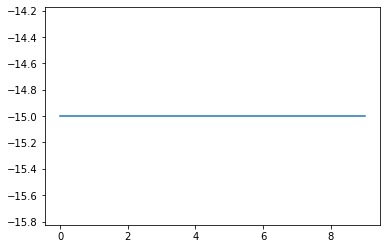

In [36]:
model = DDQNetwork(env)
model.loadModel("checkpoint_5000000_model.pt")
a = DDQAgent(env, model)
a.run(10)
data = a.getData()

plt.plot(data)
plt.show()

In [13]:
import gc

gc.collect()

T.cuda.empty_cache()